# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [ ]:
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used
# !pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.3 opencv-python==4.8.0.76 -q --user

In [ ]:
# Installing the libraries with the specified version.
# uncomment and run the following lines if Jupyter Notebook is being used
#!pip install tensorflow==2.13.0 scikit-learn==1.2.2 seaborn==0.11.1 matplotlib==3.3.4 numpy==1.24.3 pandas==1.5.2 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [80]:
import os
from pickletools import uint8

import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations                
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.image import (resize, 
                              resize_with_crop_or_pad,
                              rot90, 
                              random_flip_left_right)
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import (Dense,
                                     Dropout,
                                     Flatten,
                                     Conv2D,
                                     MaxPooling2D,
                                     BatchNormalization,
                                     Input)                                                      # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from tensorflow.keras.utils import to_categorical                                                # Importing function used to convert class vectors (integers) into
                                                                                                 # binary class matrix (one-hot encoding).
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer
# Display images using OpenCV
# from google.colab.patches import cv2_imshow                                                    # Importing cv2_imshow from google.patches to display images
import cv2                                                                                       # Importing openCV for image processing
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [2]:
# Uncomment and run the below code if you are using google colab
# from google.colab import drive
# drive.mount('/content/drive')

In [36]:
# Load the image file of dataset
images = np.load('images.npy')      # Complete the code to read the dataset

# Load the labels file of dataset
labels = pd.read_csv('Labels.csv')  # Complete the code to read the dataset

## Data Overview

### Understand the shape of the dataset

In [37]:
images.shape

(4750, 128, 128, 3)

In [38]:
labels.shape

(4750, 1)

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [39]:
labels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


In [40]:
labels.nunique()

Label    12
dtype: int64

In [41]:
labels_list = labels['Label'].unique().tolist()
print(labels_list)

['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse', 'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers', 'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass', 'Loose Silky-bent']


In [42]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

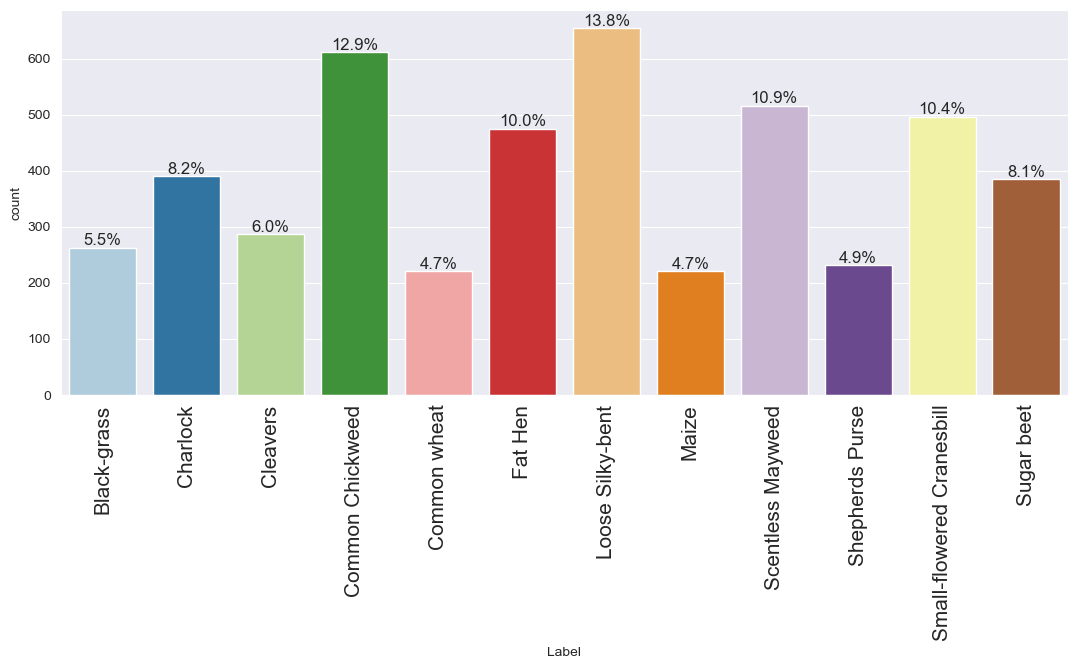

In [43]:
labeled_barplot(labels, 'Label', perc=True)

In [44]:
print(labels['Label'].iloc[10])

Small-flowered Cranesbill


In [45]:
import random

def plot_random_images(number=10, image_array=images, label_array=labels, random=True, channels='BGR'):
    '''
    plot images
    :param number: number of images to plot 
    :param image_array: image array in BGR format
    :param label_array: array of labels
    :param random: select images randomly (default) or take first 10 (or number) images
    :return: none
    '''
    # Plot multiple images as subplots
    fig, axes = plt.subplots(number // 5 + (number % 5 > 0), 5, figsize=(20, 20))

    for i in range(number):
        if random:
            r1 = random.randint(0, number)
        else:
            r1 = i
        ax = axes[i // 5, i % 5]
        if channels == 'BGR':
            ax.imshow(cv2.cvtColor(image_array[r1], cv2.COLOR_BGR2RGB))
        else:
            ax.imshow(image_array[r1])
        ax.set_title(label_array['Label'].iloc[r1])

    plt.tight_layout()
    plt.show()
    

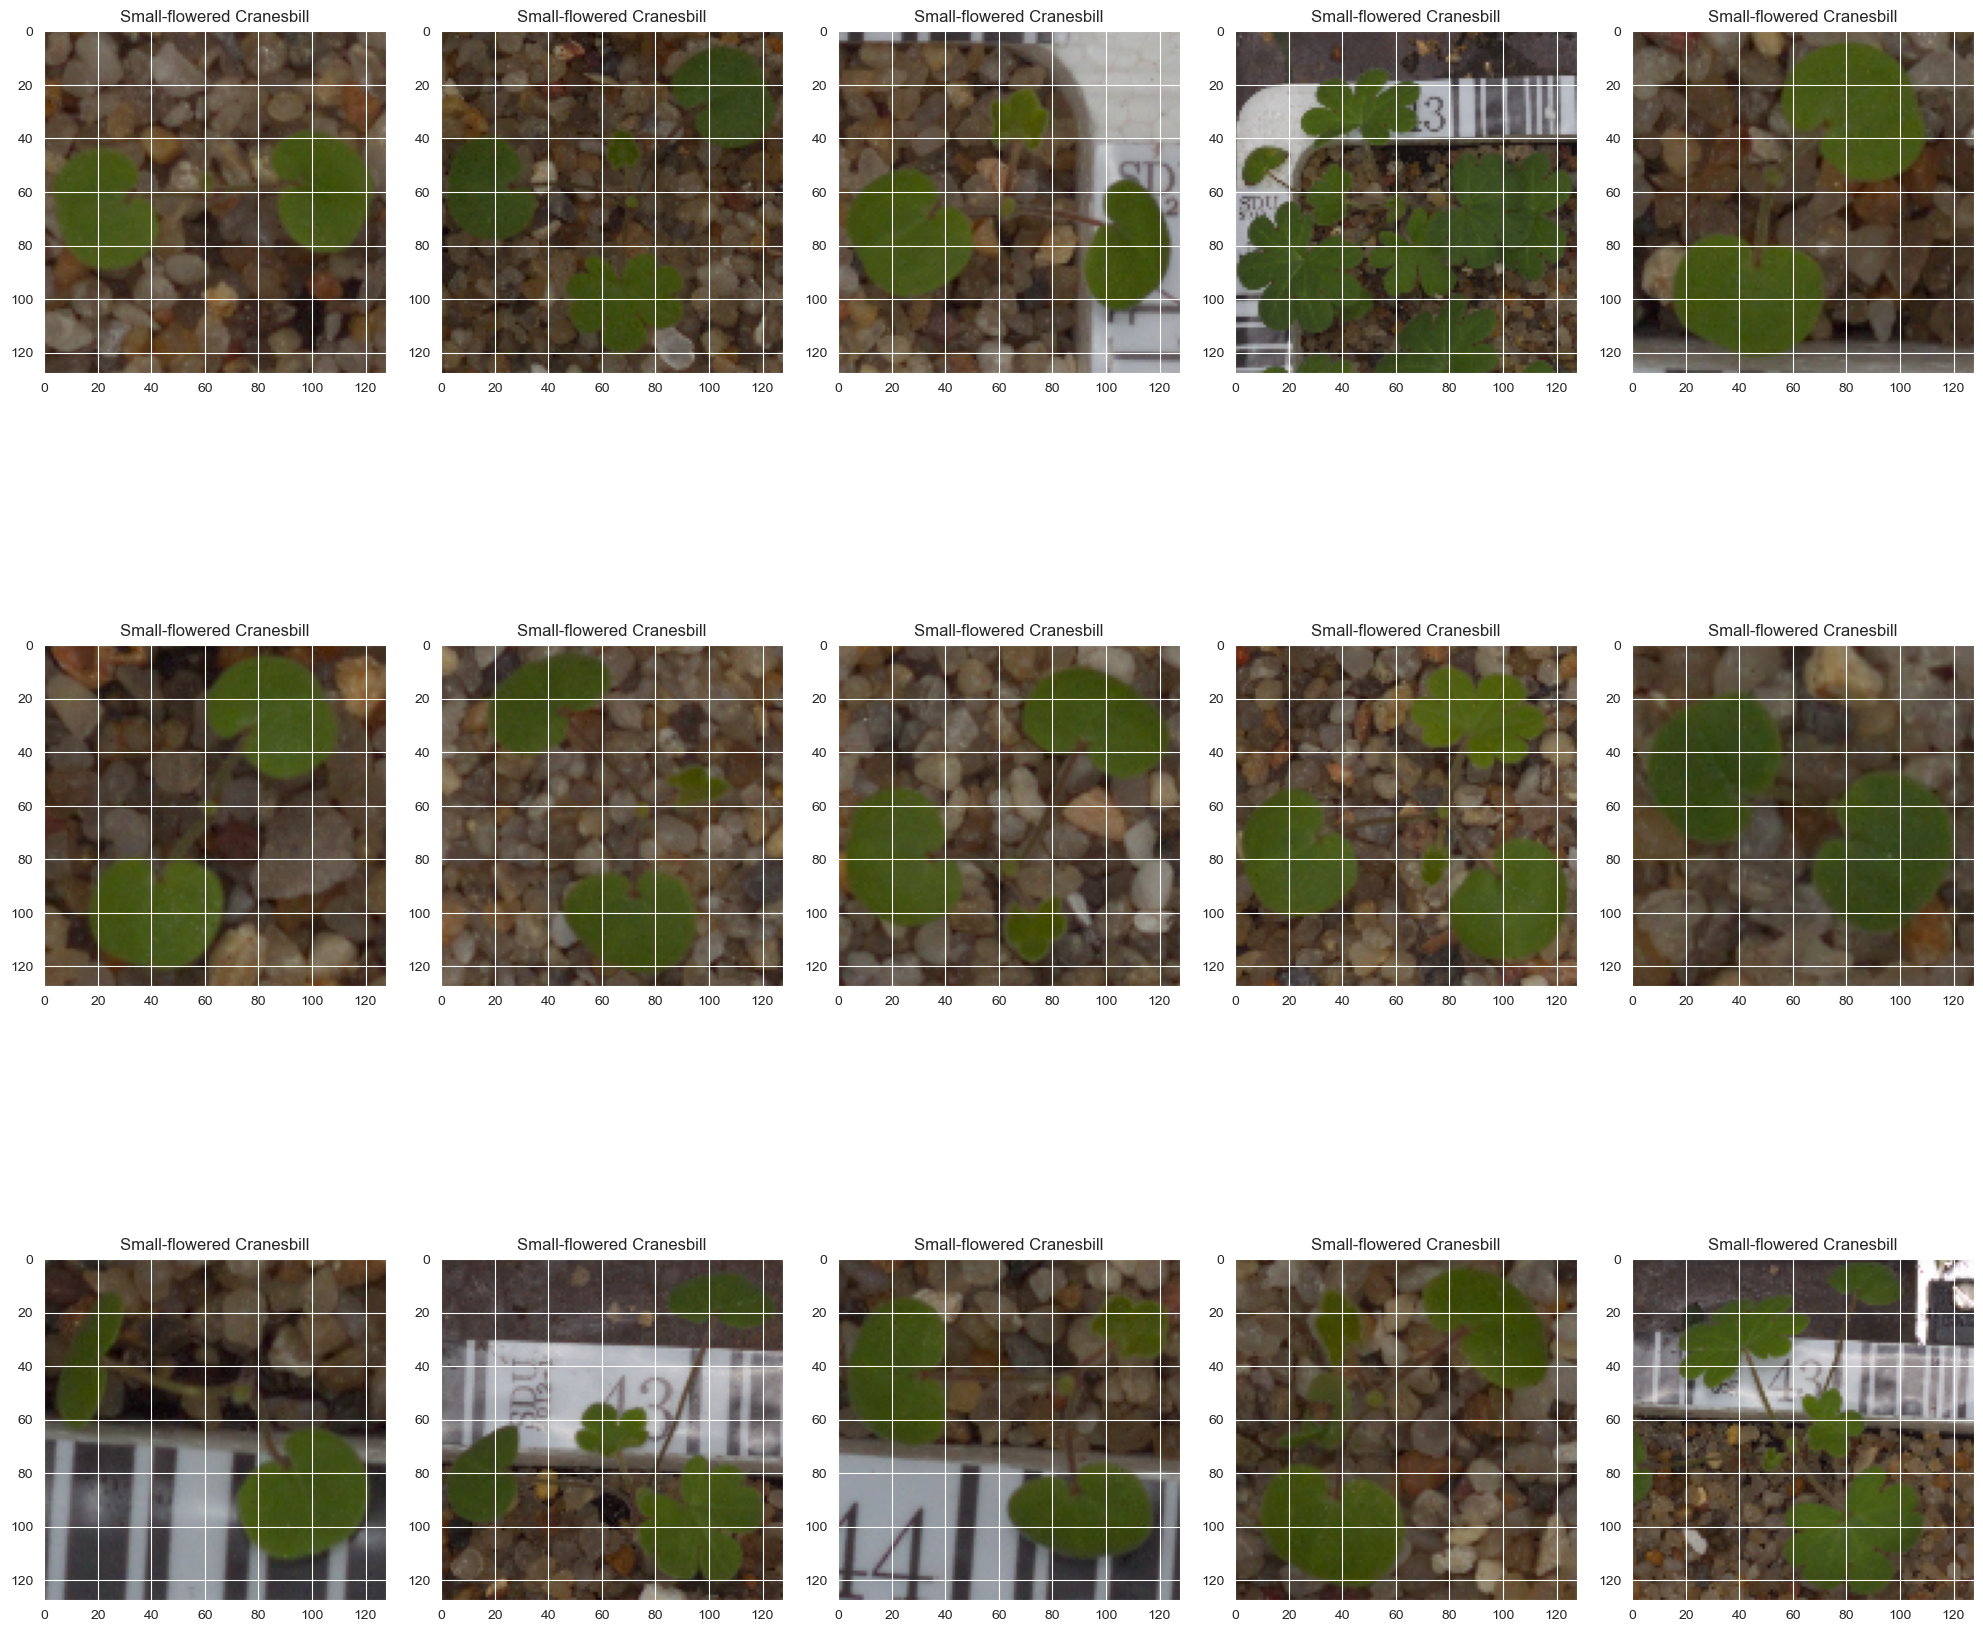

In [46]:
plot_random_images(15, images, labels, random=False)

## Data Pre-Processing

In [47]:
for i in range(len(images)):
    images[i] = cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0)

### Convert the BGR images to RGB images.

We won't convert the images in RGB as we have adapted our code to handle BGR and we keep the main data strcuture in BRG and only convert in RGB to display the image(s) only

In [48]:
images_bgr = images.copy()
#for i in range(len(images)):
#    images_bgr[i] = cv2.cvtColor(images[i], cv2.COLOR_RGB2BGR)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [49]:
images_bgr.shape

(4750, 128, 128, 3)

In [50]:
images_bgr_resized = np.empty((4750, 64, 64, 3), dtype=np.uint8)
for i in range(len(images_bgr)):
    images_bgr_resized[i] = cv2.resize(images_bgr[i], (64, 64), interpolation=cv2.INTER_LINEAR)
    
print(images_bgr_resized.shape)

(4750, 64, 64, 3)


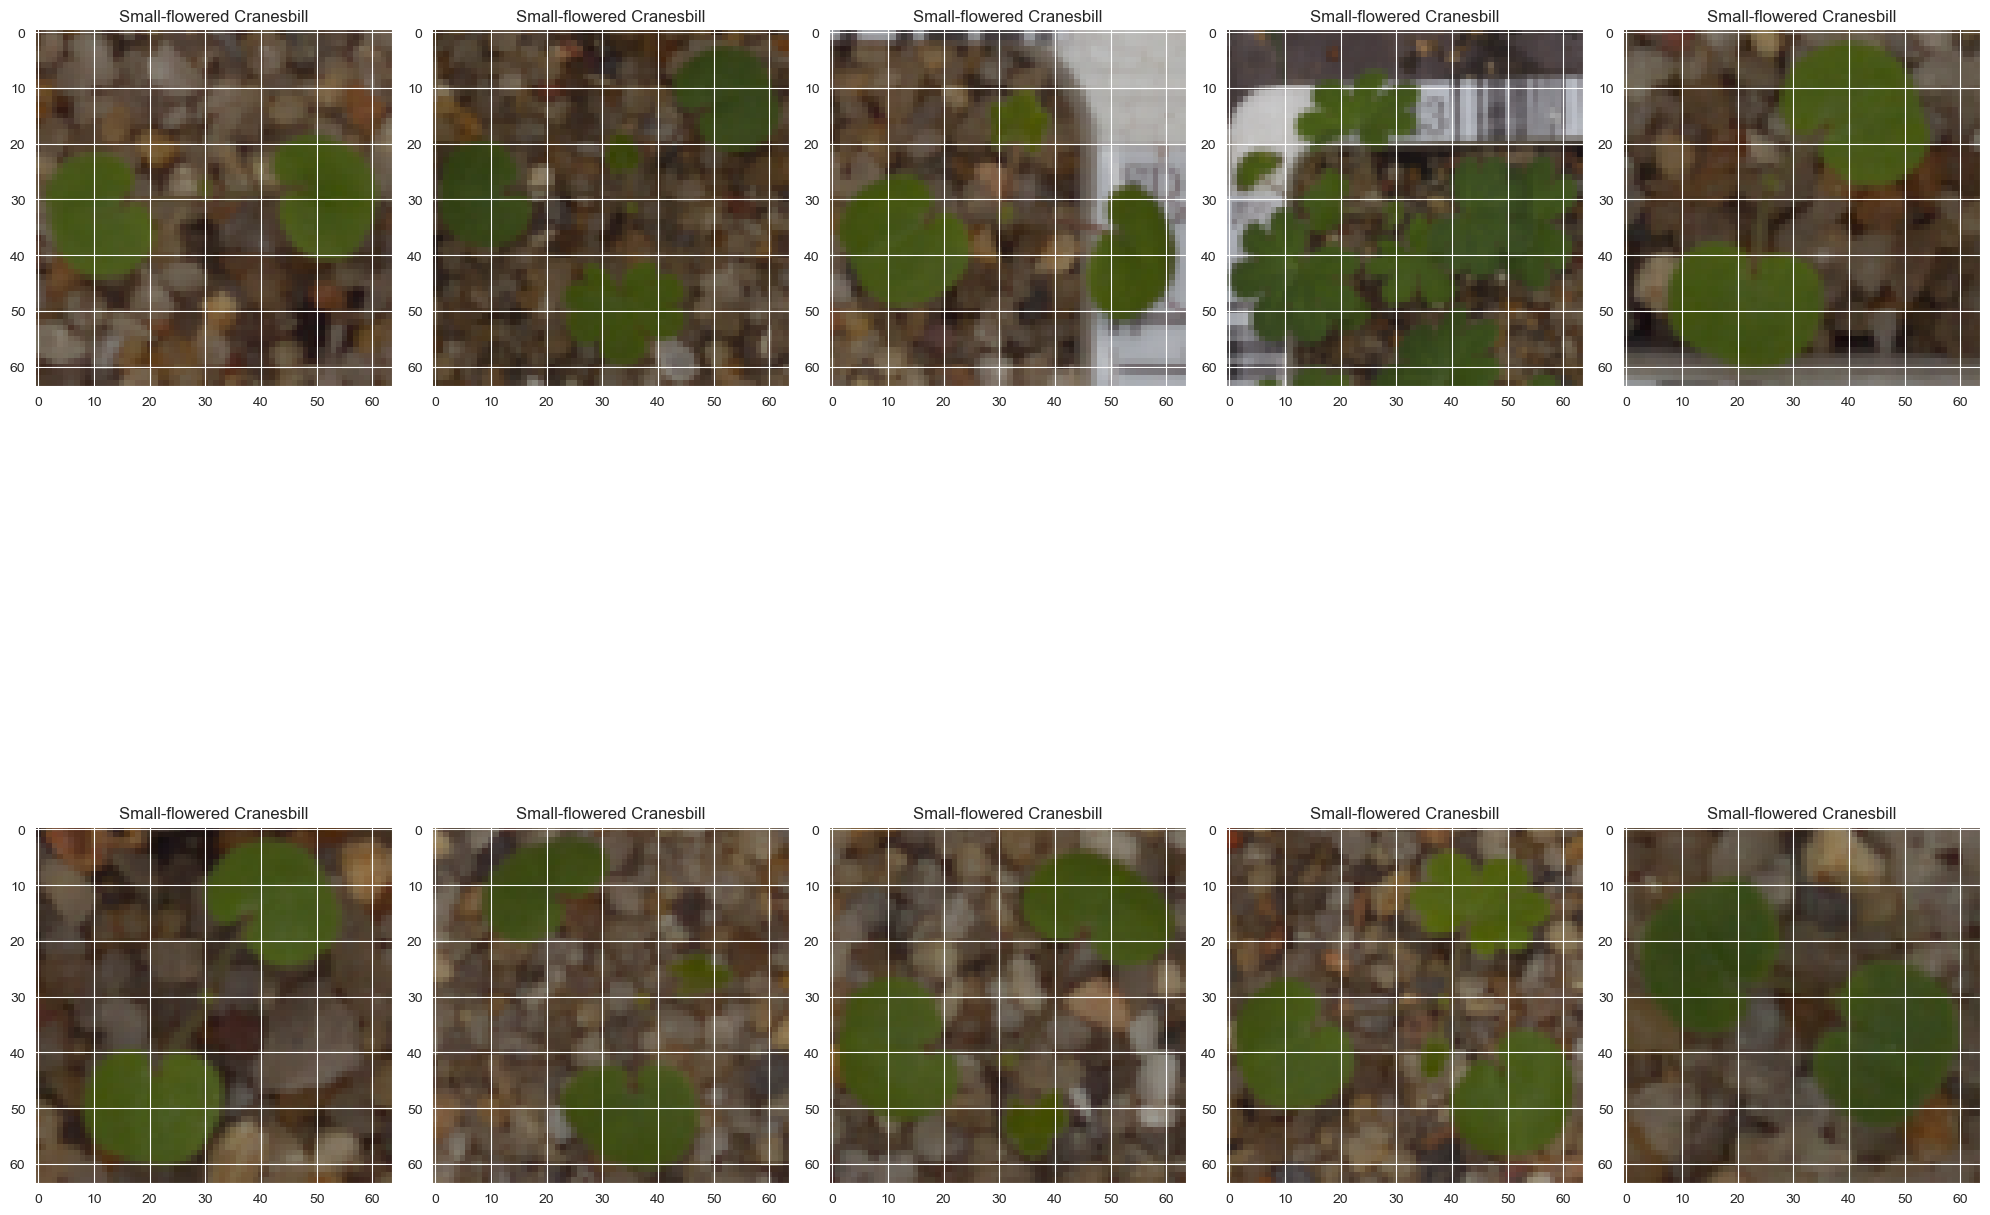

In [51]:
plot_random_images(10, images_bgr_resized, labels, random=False, channels='BGR')

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

### Encode the target labels


In [52]:
num_classes = labels['Label'].nunique()
y = LabelBinarizer().fit_transform(labels['Label'])

print(y[0])

[0 0 0 0 0 0 0 0 0 0 1 0]


### Data Normalization

In [53]:

def data_normalization(data):
    '''
    Normalize the data
    :param data: the data to be normalized
    :return: the normalized data
    '''
    return data.astype('float32') / 255.0

In [54]:
X_test = data_normalization(X_test)
X_val = data_normalization(X_val)
X_train = data_normalization(X_train)

### Split the dataset


In [55]:
# Splitting data into training, validation and test set:
# first we split data into 2 parts, say temporary and test
X_temp, X_test, y_temp, y_test = train_test_split(
    images_bgr_resized, y, test_size=0.2, random_state=42, stratify=y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(2850, 64, 64, 3) (950, 64, 64, 3) (950, 64, 64, 3)
(2850, 12) (950, 12) (950, 12)


## Model Building

### Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [94]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### Data Augmentation
Remember, **data augmentation should not be used in the validation/test data set**.

In [150]:
# Custom function to randomly flip images horizontally
def random_flip(image):
    '''
    Randomly flips an image horizontally
    :param image: image to flip
    :return: flipped image
    '''
    return random_flip_left_right(image)

# Custom function to randomly rotate images
def random_rotate(image, max_angle=10):
    '''
    Randomly rotates an image
    :param image: image to rotate
    :param max_angle: range of the random rotation
    :return: rotated image
    '''
    angle = tf.random.uniform([], -max_angle, max_angle, dtype=tf.float32)
    return rot90(image, k=tf.cast(angle // 90, tf.int32))

# Custom function to randomly zoom images
def random_zoom(image, zoom_range=(1, 1)):
    '''
    Randomly zooms an image
    :param image: image to zoom
    :param zoom_range: zoomed range
    :return:  zoomed image range
    '''
    zoom_factor = tf.random.uniform([], zoom_range[0], zoom_range[1])
    img_shape = tf.shape(image)
    height, width = img_shape[0], img_shape[1]

    new_height = tf.cast(zoom_factor * tf.cast(height, tf.float32), tf.int32)
    new_width = tf.cast(zoom_factor * tf.cast(width, tf.float32), tf.int32)

    # Ensure new_height and new_width are not zero
    new_height = tf.maximum(1, new_height) # Changed from 0 to 1
    new_width = tf.maximum(1, new_width) # Changed from 0 to 1
    
    # Resize and then crop back to original size
    image_resized = resize(image, [new_height, new_width])
    image_cropped = resize_with_crop_or_pad(image_resized, height, width)
    return image_cropped

# Custome function to randomly zoom images using OpenCV as still have troubles with the Terraflow APIs
def random_zoom_cv(image, zoom_range=(0.9, 1.1)):
    '''
    Randomly zooms an image using OpenCV
    :param image: image to zoom
    :param zoom_range: zoomed range
    :return: zoomed image
    '''
    zoom_factor = np.random.uniform(zoom_range[0], zoom_range[1])
    img_shape = image.shape
    height, width = img_shape[0], img_shape[1]

    new_height = int(zoom_factor * height)
    new_width = int(zoom_factor * width)

    # Ensure new_height and new_width are not zero
    new_height = max(1, new_height)
    new_width = max(1, new_width)


    # Use tf.numpy_function with explicit output shape
    image_resized = tf.numpy_function(lambda x: cv2.resize(x, (new_width, new_height), interpolation=cv2.INTER_LINEAR).astype(np.float64), [image], tf.float64)
    # Set the shape of the resized image
    image_resized.set_shape(image.shape)
    # no interpolation we want to crop the image to the original size only
    image_cropped = tf.numpy_function(lambda x: cv2.resize(x, (width, height)).astype(np.float64), [image_resized], tf.float64)
    # Set the shape of the cropped image
    image_cropped.set_shape(image.shape)

    return image_cropped

# Custom function to randomly change contrast
def random_contrast(image, contrast_range=(0.8, 1.2)):
    '''
    Adjust the contrast of the image
    :param image: image to contrast
    :param contrast_range: contrast range
    :return: constrasted image
    '''
    return tf.image.random_contrast(image, contrast_range[0], contrast_range[1])

# Combine all augmentation functions into one function
def augment_image(image):
    '''
    Apply a random combination of the following augmentations to the image:
    :param image: 
    :return: augmented image
    '''
    image = random_flip(image)
    image = random_rotate(image)
    image = random_zoom_cv(image)
    image = random_contrast(image)
    return image

In [151]:
# Convert the NumPy arrays to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Apply augmentation only to the training dataset
train_dataset = train_dataset.map(lambda x, y: (augment_image(x), y))

# Shuffle, batch, and prefetch the dataset for better performance
batch_size = 32
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

### Model building

Comment on the final model you have selected and use the same in the below code to visualize the image.

In [152]:
image_def = X_train[0].shape
image_height = image_def[0]
image_width = image_def[1]
num_channels = image_def[2]
print(f'Image size: {image_height} x {image_width} x {num_channels}')

Image size: 64 x 64 x 3


In [153]:
print(f'Number of classes: {num_classes}')

Number of classes: 12


In [154]:

model_1 = tf.keras.Sequential([
    Input(shape=(image_height, image_width, num_channels)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [155]:
# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# Generating the summary of the model
model_1.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,988 (2.47 MB)

 Trainable params: 646,988 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [156]:
history_model_1 = model_1.fit(
    train_dataset,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[learning_rate_reduction]
)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1305 - loss: 5.7865 - val_accuracy: 0.1474 - val_loss: 2.4628 - learning_rate: 0.0010
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.1255 - loss: 2.4637 - val_accuracy: 0.1389 - val_loss: 2.4779 - learning_rate: 0.0010
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.1328 - loss: 2.4293 - val_accuracy: 0.1316 - val_loss: 2.4345 - learning_rate: 0.0010
Epoch 4/30
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1314 - loss: 2.4291
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1318 - loss: 2.4286 - val_accuracy: 0.1326 - val_loss: 2.4219 - learning_rate: 0.0010
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1502 - loss: 2.4034 - val_accuracy: 0.1389 - val_loss: 2.3778 - learning_rate: 5.0000e-04
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.1608 - loss: 2.3544 - val_

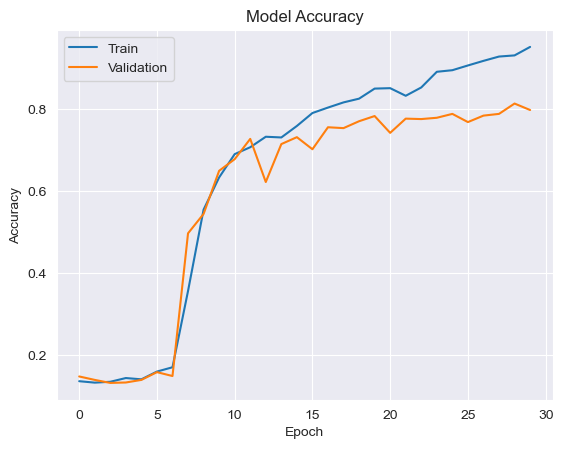

In [157]:
plt.plot(history_model_1.history['accuracy'])
plt.plot(history_model_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [158]:
# Here we would get the output as probablities for each category
y_pred_val=model_1.predict(X_val)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [159]:
def plot_confusion_matrix(y_pred, y_test_encoded, classes,):
    # Obtaining the categorical values from y_test_encoded and y_pred
    y_pred_arg=np.argmax(y_pred,axis=1)
    y_test_arg=np.argmax(y_test_encoded,axis=1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax,
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.show()

In [160]:
model_1.evaluate(X_val,(y_val))

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8083 - loss: 0.6211


[0.6870374083518982, 0.7978947162628174]

In [161]:
y_pred_val = model_1.predict(X_val)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


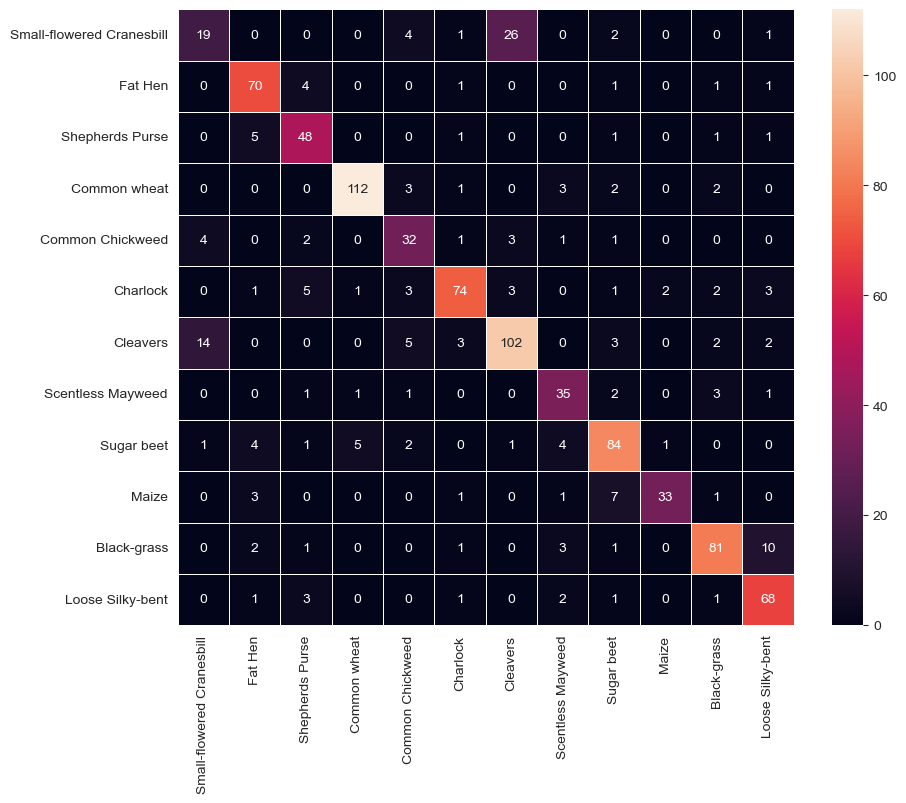

In [162]:
plot_confusion_matrix(y_pred_val, y_val, labels_list)

### Visualizing the prediction

## Final Model
Comment on the final model you have selected and use the same in the below code to visualize the image.

### Visualizing the prediction

## Actionable Insights and Business Recommendations

*

# Annex


In [ ]:

def add_new_element_at_index(image_array, image, index):
    '''
    Insert a augmented image into the image array at the specified index
    :param an array of images: 
    :param image: the new image to insert in the array
    :param index: the index at which will insrt the index
    :return: the new image array
    '''
    # Create a new image array with one extra row
    new_array = np.empty((image_array.shape[0] + 1, image_array.shape[1]))

    # Copy the elements from the original image array to the new array, inserting the image at the specified index
    new_array[np.r_[:index, index + 1:]] = image_array
    new_array[index] = image
    return new_array

In [ ]:

def augment_image2(image):
    '''
    Apply random transformations to the image
    :param image: 
    :return: the augmented image
    '''
    # Geometric transformations
    if random.random() < 0.5:
        image = cv2.flip(image, 1)  # Horizontal flip

    if random.random() < 0.5:
        angle = random.randint(-30, 30)  # Rotation
        M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
        image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    if random.random() < 0.5:
        scale_factor = random.uniform(0.8, 1.2)  # Scaling
        image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)

    # Color transformations
    if random.random() < 0.5:
        brightness_factor = random.uniform(0.5, 1.5)  # Brightness adjustment
        image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)

    if random.random() < 0.5:
        contrast_factor = random.uniform(0.5, 1.5)  # Contrast adjustment
        image = np.clip(image * contrast_factor + (1 - contrast_factor) * 128, 0, 255).astype(np.uint8)

    return image

_____